In [11]:
%pip install pandas matplotlib seaborn statsmodels scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error

# Configuração visual
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (15, 10) # Gráfico grande para ver detalhes

Note: you may need to restart the kernel to use updated packages.


In [12]:
df = pd.read_csv('../data/vendas.csv')
df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True, errors='coerce')
df = df.sort_values('Order Date')

print("Regiões disponíveis:", df['Region'].unique())

Regiões disponíveis: ['Central' 'East' 'West' 'South']


🔄 Processando Região: Central...
🔄 Processando Região: East...


c:\Users\pedro\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\pedro\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


🔄 Processando Região: West...
🔄 Processando Região: South...


c:\Users\pedro\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\pedro\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


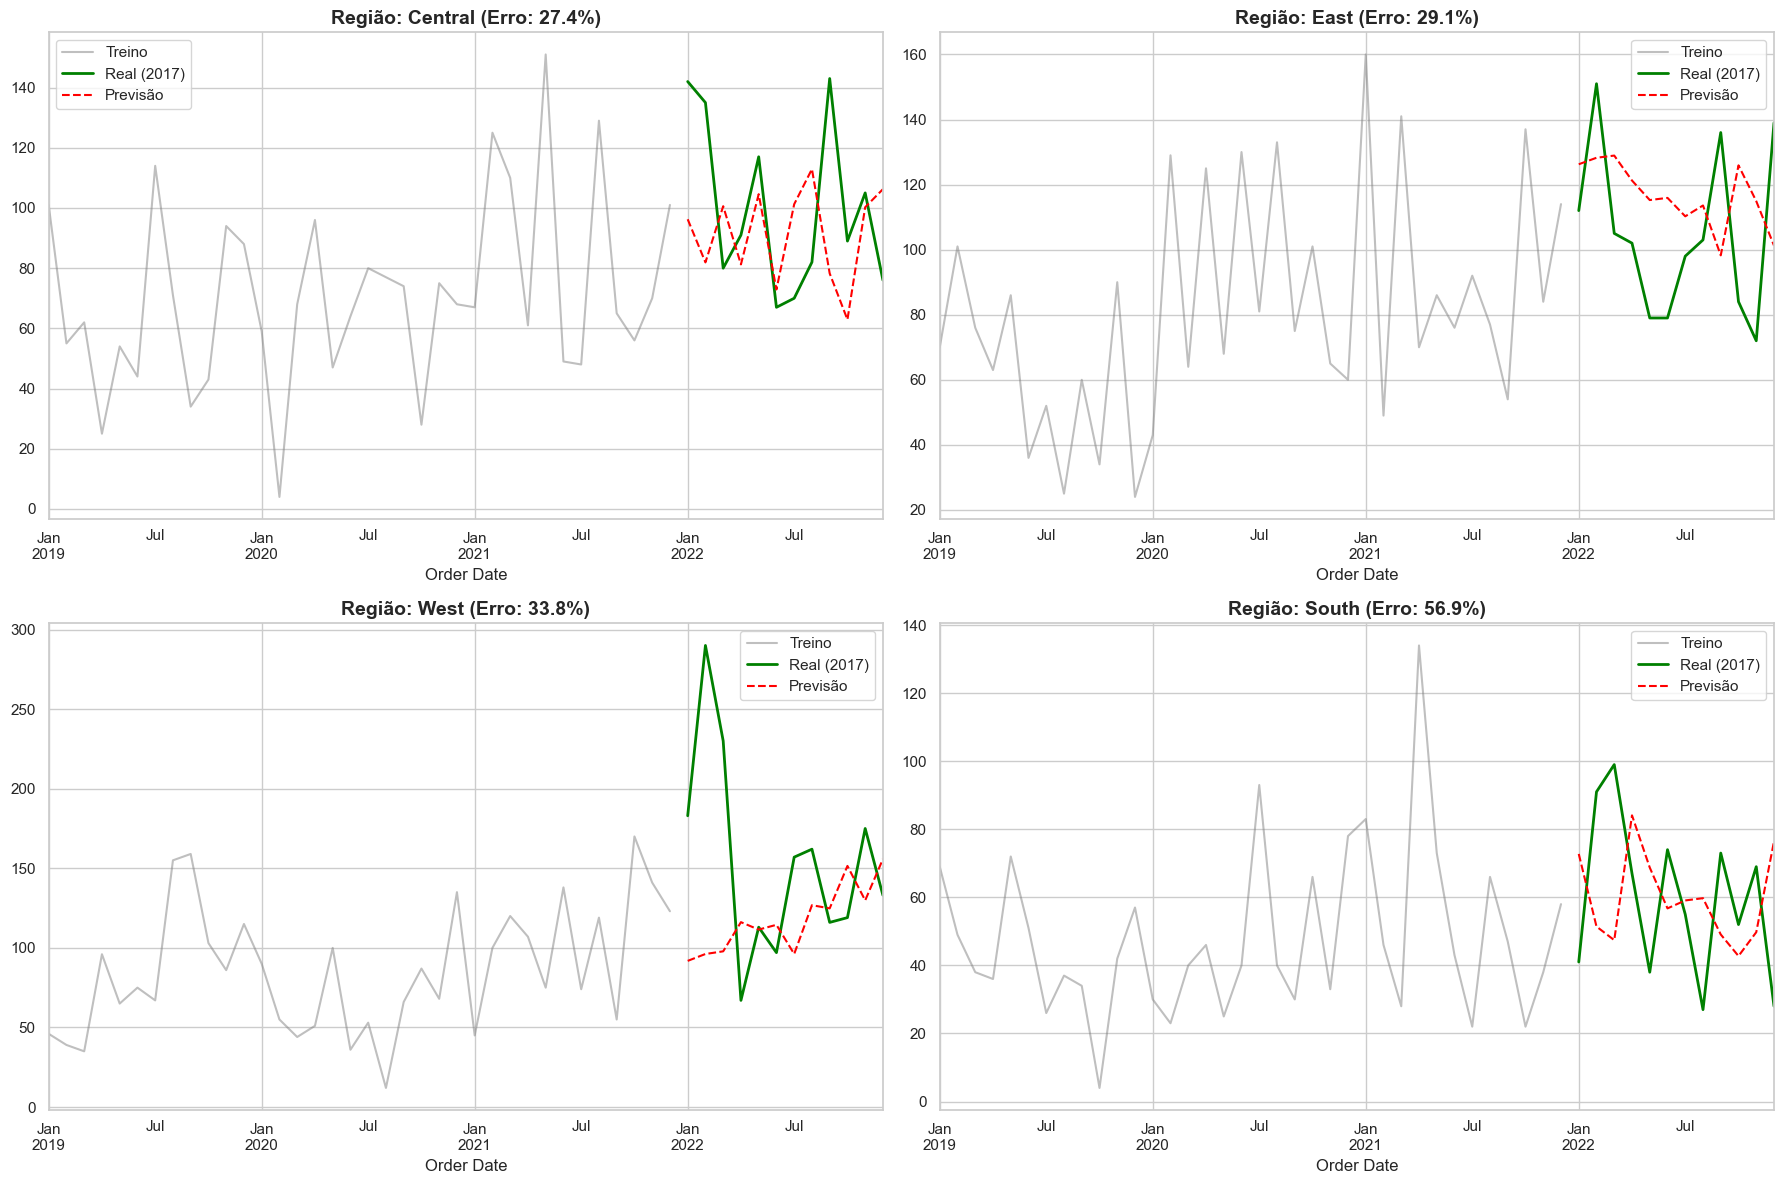

In [13]:
resultados = []
regions = df['Region'].unique()

# Prepara a grade de gráficos (2 linhas, 2 colunas)
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten() # Facilita acessar os gráficos pelo índice 0, 1, 2, 3

for i, region in enumerate(regions):
    print(f"🔄 Processando Região: {region}...")

    # 1. Filtrar e Transformar (ETL Local)
    # Pegamos só a região atual e agrupamos por mês
    df_region = df[df['Region'] == region].set_index('Order Date')['Quantity'].resample('MS').sum()

    # 2. Divisão Treino/Teste (Últimos 12 meses para teste)
    treino = df_region.iloc[:-12]
    teste = df_region.iloc[-12:]

    # 3. Treinar Modelo (Holt-Winters Aditivo)
    # Usamos o Aditivo pois venceu a batalha global
    modelo = ExponentialSmoothing(
        treino,
        trend='add',
        seasonal='add',
        seasonal_periods=12
    ).fit()

    # 4. Prever
    previsao = modelo.forecast(steps=12)

    # 5. Calcular Erro (MAPE)
    # Fórmula: Média do |(Real - Previsto) / Real|
    mape = np.mean(np.abs((teste - previsao) / teste)) * 100
    resultados.append({'Região': region, 'Erro (MAPE)': f"{mape:.2f}%"})

    # 6. Plotar no quadradinho certo
    ax = axes[i]
    treino.plot(ax=ax, label='Treino', color='gray', alpha=0.5)
    teste.plot(ax=ax, label='Real (2017)', color='green', linewidth=2)
    previsao.plot(ax=ax, label='Previsão', color='red', linestyle='--')
    
    ax.set_title(f"Região: {region} (Erro: {mape:.1f}%)", fontsize=14, fontweight='bold')
    ax.legend()

plt.tight_layout()
plt.show()

In [18]:
print("\n--- PLACAR FINAL POR REGIÃO ---")
df_resultados = pd.DataFrame(resultados)
print(df_resultados)

# Vamos investigar o volume de vendas
print("\n--- Investigação de Volume (Média Mensal) ---")
for region in regions:
    # Calcula quanto essa região vende em média por mês
    media_vendas = df[df['Region'] == region].set_index('Order Date')['Quantity'].resample('MS').sum().mean()
    print(f"Região {region}: Vende em média {media_vendas:.0f} produtos/mês")


--- PLACAR FINAL POR REGIÃO ---
    Região Erro (MAPE)
0  Central      27.39%
1     East      29.10%
2     West      33.77%
3    South      56.90%

--- Investigação de Volume (Média Mensal) ---
Região Central: Vende em média 78 produtos/mês
Região East: Vende em média 87 produtos/mês
Região West: Vende em média 103 produtos/mês
Região South: Vende em média 51 produtos/mês
